In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

#from sklearn import OneHotEncoder

# per importare cose nella folder precedente da ora in poi
import sys
sys.path.append('../')

from layer import HiddenLayer
from activations import *
from losses import *
from network import Network
from regularizers import *
from utils import *
from metrics import *
from validation import *

random.seed(42)
np.random.seed(42)

# Progress bar
from tqdm import tqdm
import time

In [2]:
X_train, y_train, test = read_cup("../data/ML-CUP23-TR.csv", "../data/ML-CUP23-TS.csv")

In [ ]:
seed = 3
np.random.seed(seed)
net = Network(MSE(1), eta=1e-4)

net.add_layer(
    input_size=len(X_train[0]),
    units_size=16,
    starting=Range_random(),
    regularizer=L2(lambda_=1e-6),
    activation=ReLU(),
    momentum=('Standard',1e-5)
)


net.add_layer(
    input_size=16,
    units_size=16,
    starting=Range_random(),
    regularizer=L2(lambda_=1e-6),
    activation=Identity(),
    momentum=('Standard',1e-5)
)
net.add_layer(
    input_size=16,
    units_size=3,
    starting=Range_random(),
    regularizer=L2(lambda_=1e-6),
    activation=Identity(),
    momentum=('Standard',1e-5)
)

In [ ]:
seed = 3

net = create_all_net(
    seed=seed,
    loss="MSE",
    batch_size=1,
    input_size=len(X_train[0]),
    num_layer=3,
    layers_size=[16,16,3],
    starting=["Range_random", "Range_random", "Range_random"],
    starting_range=[(-0.5,0.5),(-0.5,0.5),(-0.5,0.5)],
    activations=["ReLU", "ReLU", "Identity"],
    regularizers=["L2", "None", "L2"],
    regularizers_lambda=[1e-6,0,1e-6],
    momentums=[("Standard", 1e-5), ("None", 0), ("Standard", 1e-5)],
    eta=1e-4
)

In [ ]:

regularizers=["L2", "None", "L2"]
regularizers_lambda=[1e-6,0,1e-6]
regularizers_ = []

for i, reg in enumerate(regularizers):
    print(reg)
    if reg != "None":
        regularizers_.append(eval(reg)(lambda_=regularizers_lambda[i]))
    else:
        regularizers_.append(None)

for i in regularizers_:
    print(type(i))

In [ ]:
print(net)
type(net.loss)


In [ ]:
statistics = kfold_crossval(
    X=X_train,
    y=y_train,
    k=6,
    net=net,
    epochs=2500,
    patience=100,
    seed=seed,
    metric=MEE()
)

print(statistics)

In [3]:
import itertools

# Define the hyperparameters as dictionaries
hyperparameters = {
    'losses': ["MSE"],
    'layers_sizes': [[32,32,3],[16,16,16,3]],
    'activations': ["ReLU"], 
    'startings': ["Range_random"],
    'startings_range': [(-0.5, 0.5)],
    'regularizers': ["L2"],
    'regularizers_lambda': [1e-6, 1e-8],
    'momentums': [('Nesterov', 1e-4), ('Standard', 1e-4)],
    'etas': [1e-4]
}

# Create a list of all the possible combinations using itertools.product
hyperparameter_combinations = list(itertools.product(*hyperparameters.values()))

all_dics = []
# Print the result or use it as needed
for combination in hyperparameter_combinations:
    hyperparameter_dict = dict(zip(hyperparameters.keys(), combination))
    print(hyperparameter_dict)
    all_dics.append(hyperparameter_dict)

{'losses': 'MSE', 'layers_sizes': [32, 32, 3], 'activations': 'ReLU', 'startings': 'Range_random', 'startings_range': (-0.5, 0.5), 'regularizers': 'L2', 'regularizers_lambda': 1e-06, 'momentums': ('Nesterov', 0.0001), 'etas': 0.0001}
{'losses': 'MSE', 'layers_sizes': [32, 32, 3], 'activations': 'ReLU', 'startings': 'Range_random', 'startings_range': (-0.5, 0.5), 'regularizers': 'L2', 'regularizers_lambda': 1e-06, 'momentums': ('Standard', 0.0001), 'etas': 0.0001}
{'losses': 'MSE', 'layers_sizes': [32, 32, 3], 'activations': 'ReLU', 'startings': 'Range_random', 'startings_range': (-0.5, 0.5), 'regularizers': 'L2', 'regularizers_lambda': 1e-08, 'momentums': ('Nesterov', 0.0001), 'etas': 0.0001}
{'losses': 'MSE', 'layers_sizes': [32, 32, 3], 'activations': 'ReLU', 'startings': 'Range_random', 'startings_range': (-0.5, 0.5), 'regularizers': 'L2', 'regularizers_lambda': 1e-08, 'momentums': ('Standard', 0.0001), 'etas': 0.0001}
{'losses': 'MSE', 'layers_sizes': [16, 16, 16, 3], 'activations'

In [4]:
for i in all_dics:
    print(*i.values())

MSE [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-06 ('Nesterov', 0.0001) 0.0001
MSE [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-06 ('Standard', 0.0001) 0.0001
MSE [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-08 ('Nesterov', 0.0001) 0.0001
MSE [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-08 ('Standard', 0.0001) 0.0001
MSE [16, 16, 16, 3] ReLU Range_random (-0.5, 0.5) L2 1e-06 ('Nesterov', 0.0001) 0.0001
MSE [16, 16, 16, 3] ReLU Range_random (-0.5, 0.5) L2 1e-06 ('Standard', 0.0001) 0.0001
MSE [16, 16, 16, 3] ReLU Range_random (-0.5, 0.5) L2 1e-08 ('Nesterov', 0.0001) 0.0001
MSE [16, 16, 16, 3] ReLU Range_random (-0.5, 0.5) L2 1e-08 ('Standard', 0.0001) 0.0001


In [37]:
losses_ = "MSE"

startings_ = []
startings_range_ = []
activations_ = []
regularizers_ = []
regularizers_lambda_ = []
momentums_ = []


for combination in all_dics:
    layers_sizes_ = combination['layers_sizes']
    startings_ = []
    activations_ = []
    regularizers_ = []
    regularizers_lambda_ = []
    momentums_ = []
    startings_range_ = []
    etas_ = combination['etas']
    for i in range(len(combination['layers_sizes'])):
        activations_.append(combination['activations'] if i != len(layers_sizes_)-1 else "Identity")
        startings_.append(combination['startings'])
        startings_range_.append(combination['startings_range'])
        regularizers_.append(combination['regularizers'])
        regularizers_lambda_.append(combination['regularizers_lambda'])
        momentums_.append(combination['momentums'])
    
    print(layers_sizes_)
    print(activations_)
    print(startings_)
    print(startings_range_)
    print(regularizers_)
    print(regularizers_lambda_)
    print(momentums_)
    print(etas_)
    print("\n")

[32, 32, 3]
['ReLU', 'ReLU', 'Identity']
['Range_random', 'Range_random', 'Range_random']
[(-0.5, 0.5), (-0.5, 0.5), (-0.5, 0.5)]
['L1', 'L1', 'L1']
[1e-06, 1e-06, 1e-06]
[('Nesterov', 0.0001), ('Nesterov', 0.0001), ('Nesterov', 0.0001)]
0.0001


[32, 32, 3]
['ReLU', 'ReLU', 'Identity']
['Range_random', 'Range_random', 'Range_random']
[(-0.5, 0.5), (-0.5, 0.5), (-0.5, 0.5)]
['L2', 'L2', 'L2']
[1e-06, 1e-06, 1e-06]
[('Nesterov', 0.0001), ('Nesterov', 0.0001), ('Nesterov', 0.0001)]
0.0001


[8, 8, 3]
['ReLU', 'ReLU', 'Identity']
['Range_random', 'Range_random', 'Range_random']
[(-0.5, 0.5), (-0.5, 0.5), (-0.5, 0.5)]
['L1', 'L1', 'L1']
[1e-06, 1e-06, 1e-06]
[('Nesterov', 0.0001), ('Nesterov', 0.0001), ('Nesterov', 0.0001)]
0.0001


[8, 8, 3]
['ReLU', 'ReLU', 'Identity']
['Range_random', 'Range_random', 'Range_random']
[(-0.5, 0.5), (-0.5, 0.5), (-0.5, 0.5)]
['L2', 'L2', 'L2']
[1e-06, 1e-06, 1e-06]
[('Nesterov', 0.0001), ('Nesterov', 0.0001), ('Nesterov', 0.0001)]
0.0001




In [ ]:
data_to_csv = [["Loss func","Size", "Activation", "Starting", "Range", "Regularizer", "lambda", "Momentum", "Eta", "tLoss", "tMetric", "vLoss", "vMetric"]]

Epochs:  17%|█▋        | 1722/10000 [01:53<09:05, 15.17it/s]


MSE [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-06 ('Nesterov', 0.0001) 0.0001


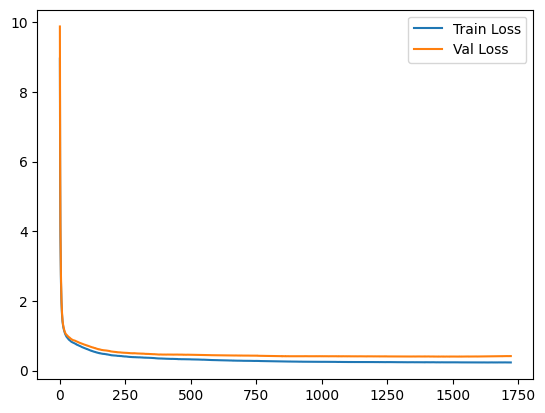

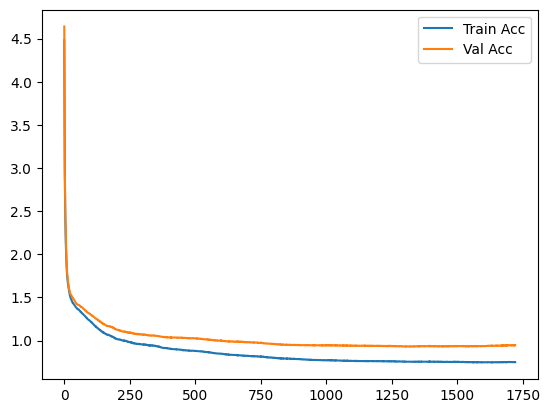

Fold 1 of 6 completed
Train Loss: 0.2317387324270215
Train Acc: 0.7485401592283178
Val Loss: 0.414736582399539
Val Acc: 0.9460887296508304


Epochs:  36%|███▌      | 3615/10000 [03:56<06:57, 15.30it/s]


MSE [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-06 ('Nesterov', 0.0001) 0.0001


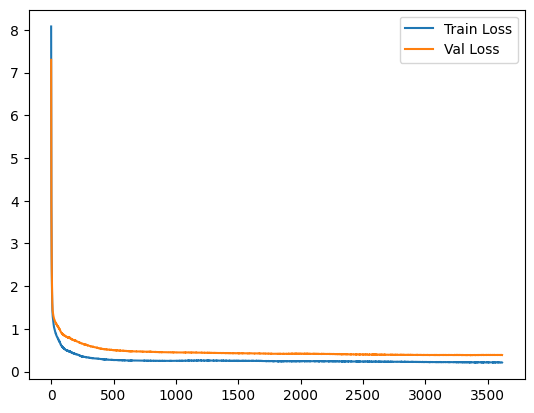

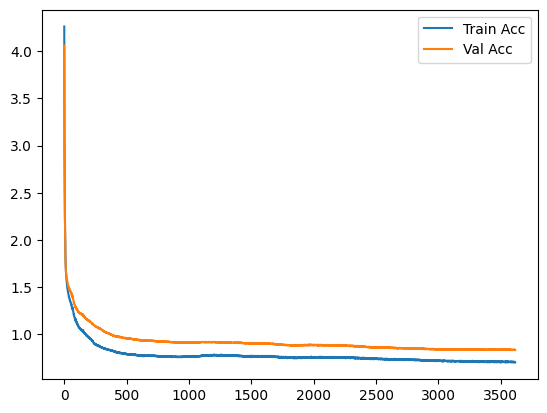

Fold 2 of 6 completed
Train Loss: 0.21468461403860248
Train Acc: 0.6987268687296745
Val Loss: 0.3900968247031291
Val Acc: 0.8313167315705252


Epochs:  21%|██▏       | 2128/10000 [02:18<08:33, 15.32it/s]


MSE [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-06 ('Nesterov', 0.0001) 0.0001


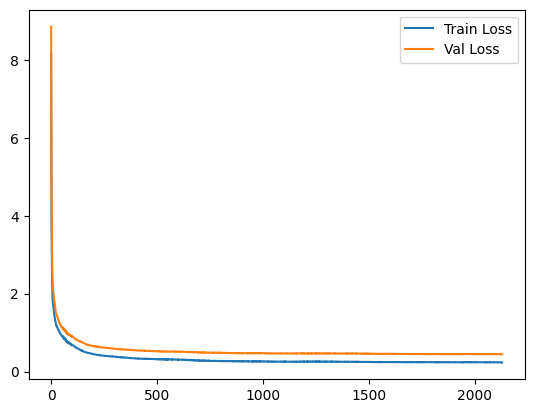

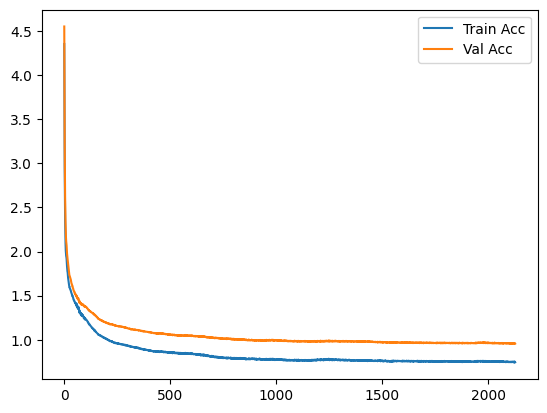

Fold 3 of 6 completed
Train Loss: 0.23245955112427286
Train Acc: 0.7448579937941431
Val Loss: 0.445710667254751
Val Acc: 0.9565648739506547


Epochs:  28%|██▊       | 2776/10000 [03:01<07:52, 15.30it/s]


MSE [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-06 ('Nesterov', 0.0001) 0.0001


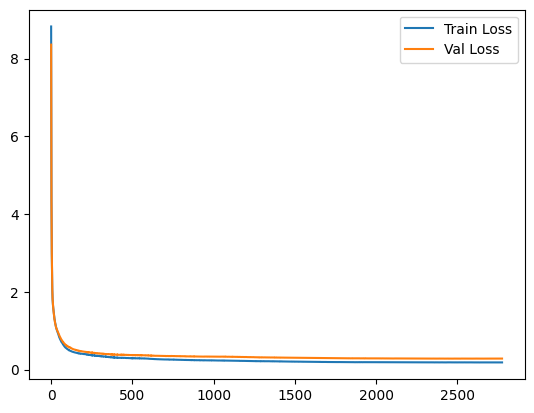

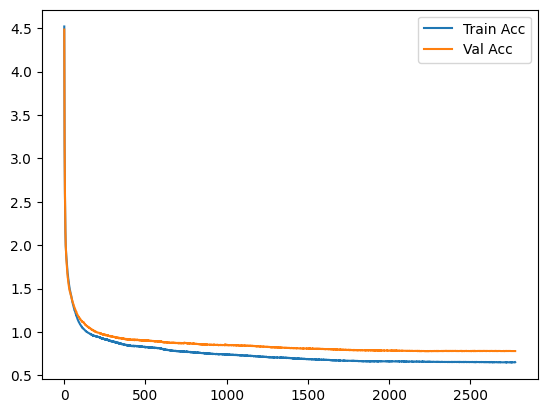

Fold 4 of 6 completed
Train Loss: 0.1859165073294859
Train Acc: 0.6526516727282458
Val Loss: 0.2847962355791515
Val Acc: 0.7813647201697731


Epochs:  14%|█▎        | 1353/10000 [01:29<09:29, 15.20it/s]


MSE [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-06 ('Nesterov', 0.0001) 0.0001


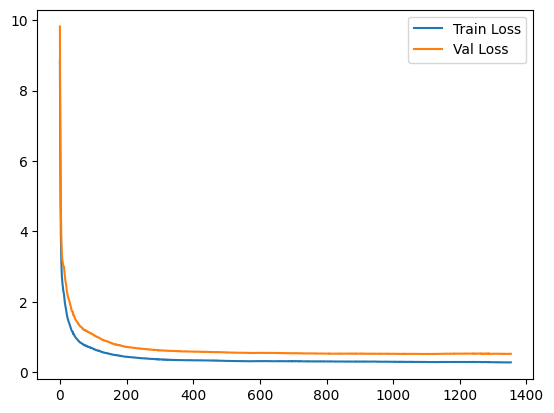

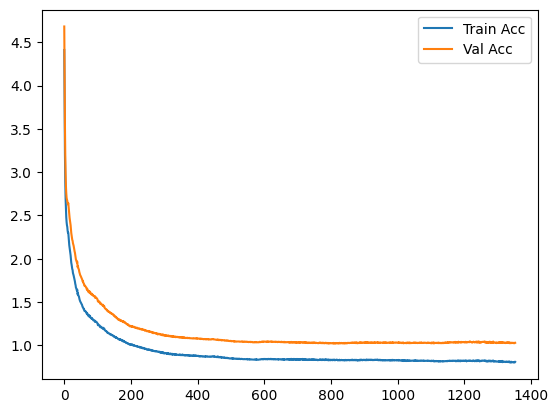

Fold 5 of 6 completed
Train Loss: 0.27786400173321113
Train Acc: 0.8089295925786089
Val Loss: 0.5195297721098373
Val Acc: 1.02897651990933


Epochs:  26%|██▌       | 2600/10000 [02:50<08:06, 15.21it/s]


MSE [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-06 ('Nesterov', 0.0001) 0.0001


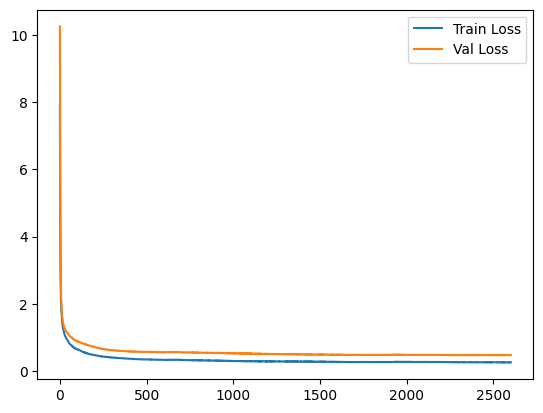

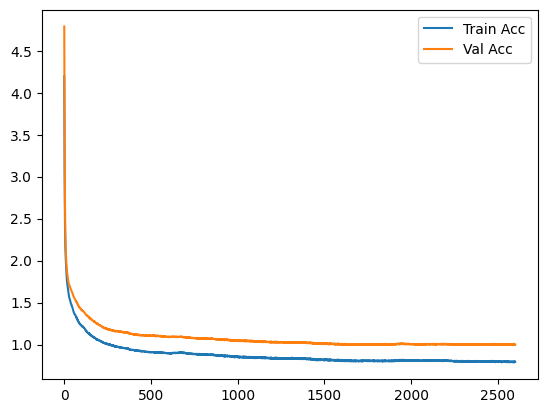

Fold 6 of 6 completed
Train Loss: 0.2657955459764326
Train Acc: 0.7943175975615627
Val Loss: 0.4793098096179131
Val Acc: 0.9980022585383077
{'tr_loss': 0.237438663473006, 'tr_metric': 0.743783796963581, 'val_loss': 0.41626918903177496, 'val_metric': 0.9195258214007667}






Epochs:  29%|██▊       | 2863/10000 [02:52<07:10, 16.57it/s]


MSE [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-06 ('Standard', 0.0001) 0.0001


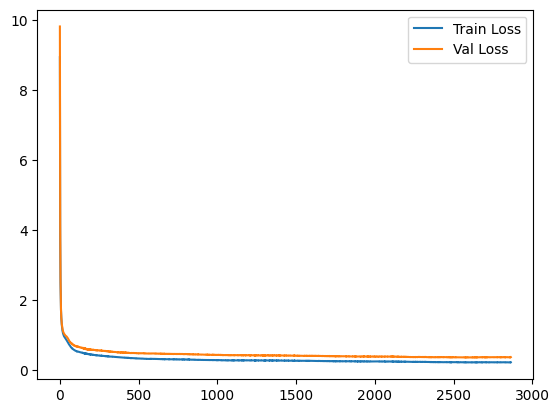

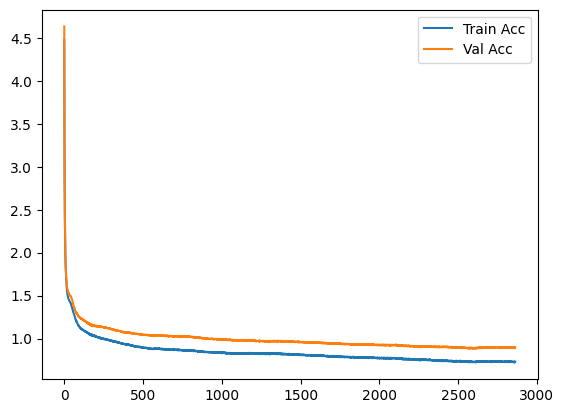

Fold 1 of 6 completed
Train Loss: 0.2149258239655194
Train Acc: 0.7311727825284347
Val Loss: 0.3626737404279269
Val Acc: 0.897417776319957


Epochs:  10%|▉         | 991/10000 [00:59<08:59, 16.70it/s]


MSE [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-06 ('Standard', 0.0001) 0.0001


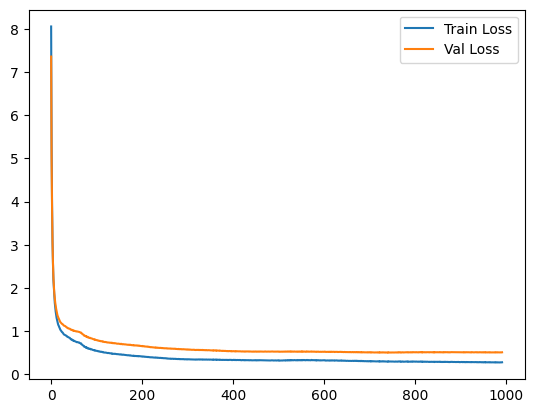

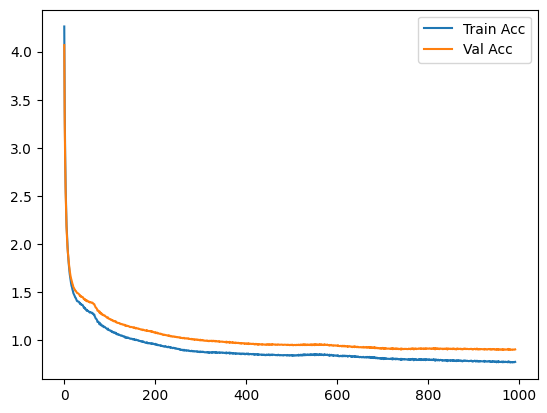

Fold 2 of 6 completed
Train Loss: 0.2740150460325622
Train Acc: 0.7767069118469623
Val Loss: 0.5053837159466047
Val Acc: 0.9066119640899468


Epochs:  16%|█▌        | 1616/10000 [01:36<08:20, 16.74it/s]


MSE [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-06 ('Standard', 0.0001) 0.0001


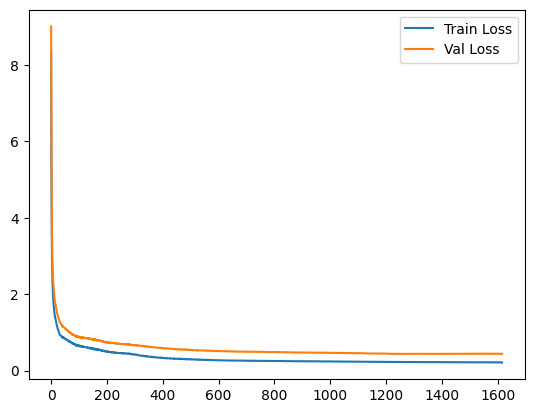

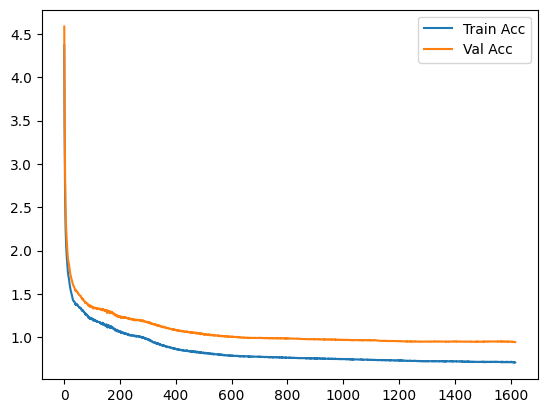

Fold 3 of 6 completed
Train Loss: 0.21449043122960262
Train Acc: 0.7102517356899234
Val Loss: 0.44125543105265863
Val Acc: 0.945549239347247


Epochs:  33%|███▎      | 3319/10000 [03:18<06:39, 16.73it/s]

MSE [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-06 ('Standard', 0.0001) 0.0001


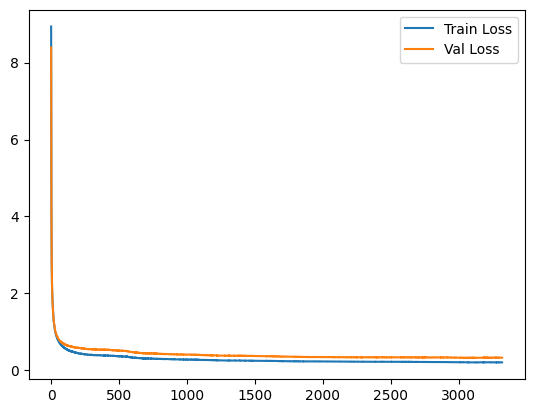

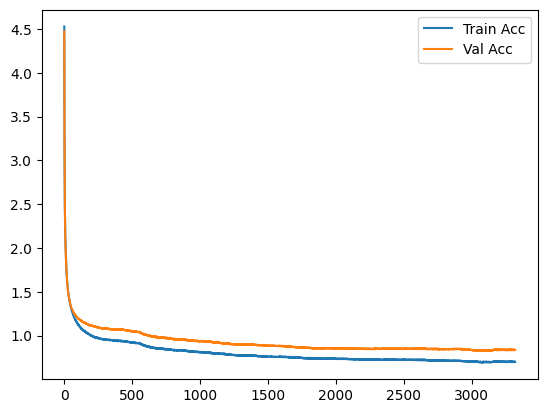

Fold 4 of 6 completed
Train Loss: 0.20756374900425362
Train Acc: 0.6985314794194692
Val Loss: 0.32954961177000974
Val Acc: 0.8360416507816655


Epochs:  24%|██▍       | 2375/10000 [02:23<07:39, 16.60it/s]

MSE [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-06 ('Standard', 0.0001) 0.0001


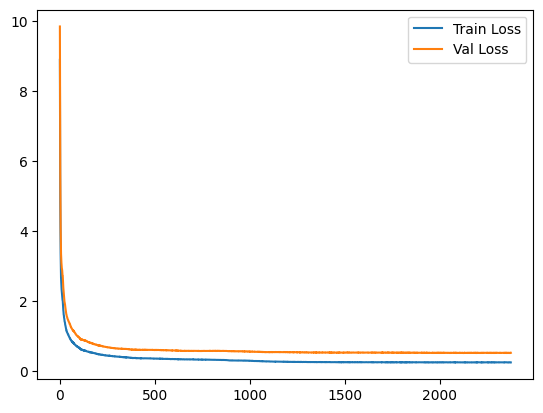

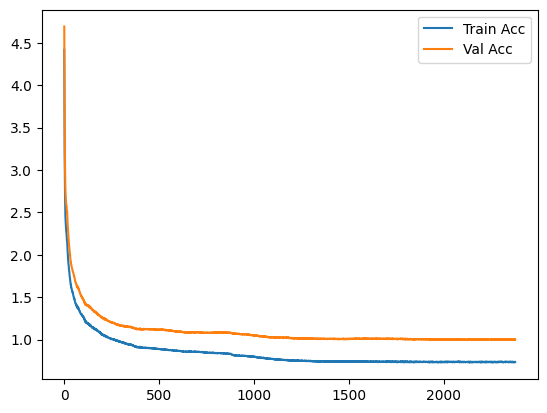

Fold 5 of 6 completed
Train Loss: 0.24191837861927418
Train Acc: 0.7344170181474019
Val Loss: 0.5147970892234628
Val Acc: 1.001489523264634


Epochs:  38%|███▊      | 3797/10000 [03:48<06:13, 16.62it/s]


MSE [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-06 ('Standard', 0.0001) 0.0001


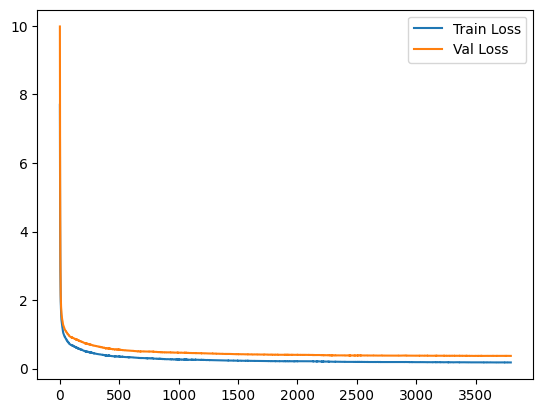

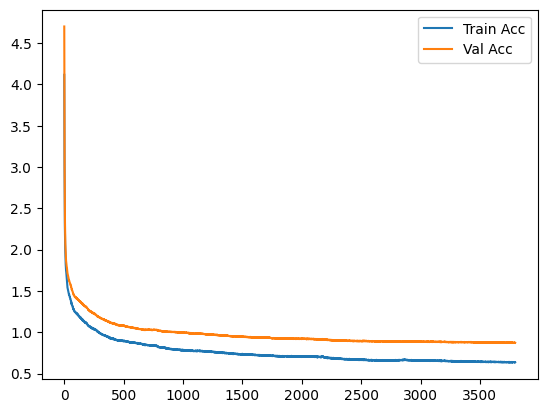

Fold 6 of 6 completed
Train Loss: 0.1786039482788158
Train Acc: 0.6369454687513769
Val Loss: 0.36978547367922954
Val Acc: 0.8729349790589326
{'tr_loss': 0.2246323096882088, 'tr_metric': 0.7179527632351629, 'val_loss': 0.41437196941752236, 'val_metric': 0.9051710946472963}






Epochs:  17%|█▋        | 1698/10000 [01:51<09:07, 15.18it/s]


MSE [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-08 ('Nesterov', 0.0001) 0.0001


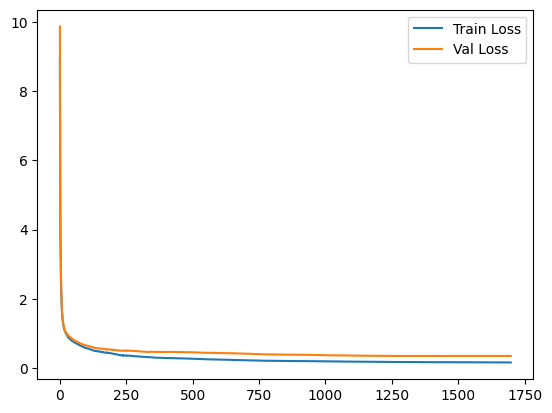

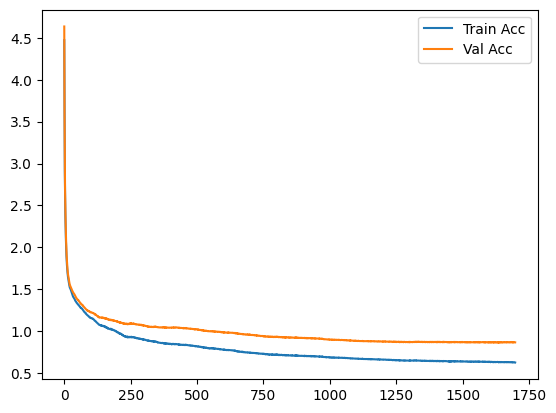

Fold 1 of 6 completed
Train Loss: 0.1583632210009102
Train Acc: 0.6269521593291998
Val Loss: 0.3476269281788916
Val Acc: 0.8671784096220793


Epochs:  32%|███▏      | 3170/10000 [03:28<07:28, 15.22it/s]


MSE [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-08 ('Nesterov', 0.0001) 0.0001


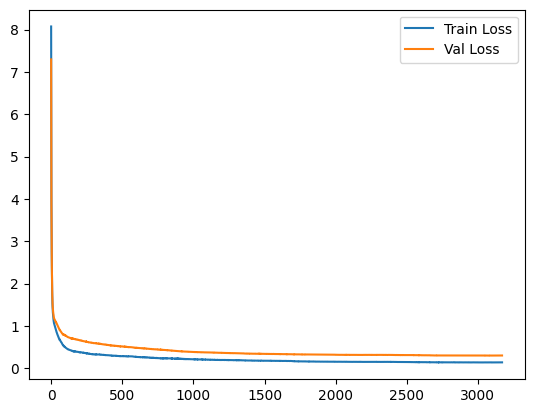

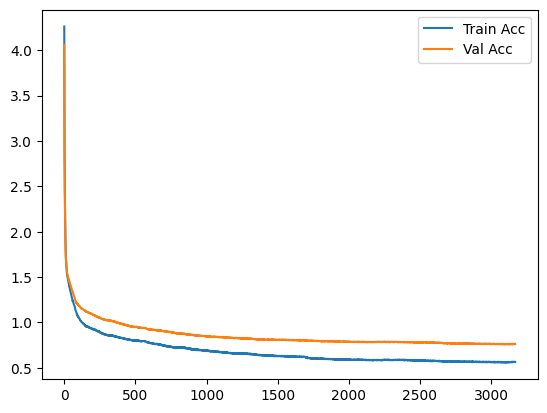

Fold 2 of 6 completed
Train Loss: 0.1369241476525126
Train Acc: 0.5655159478261571
Val Loss: 0.29925050269924175
Val Acc: 0.7628862467042447


Epochs:  24%|██▍       | 2406/10000 [02:37<08:17, 15.27it/s]


MSE [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-08 ('Nesterov', 0.0001) 0.0001


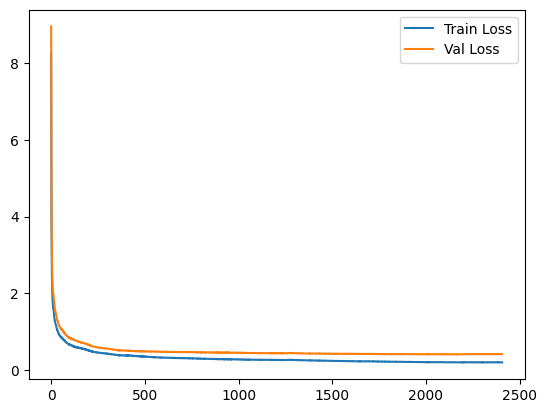

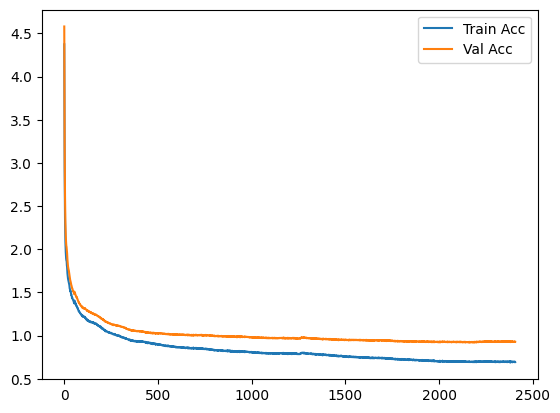

Fold 3 of 6 completed
Train Loss: 0.1974078726074387
Train Acc: 0.6933163877951329
Val Loss: 0.4143193704689378
Val Acc: 0.928917795070592


Epochs:  42%|████▏     | 4168/10000 [04:34<06:23, 15.19it/s]


MSE [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-08 ('Nesterov', 0.0001) 0.0001


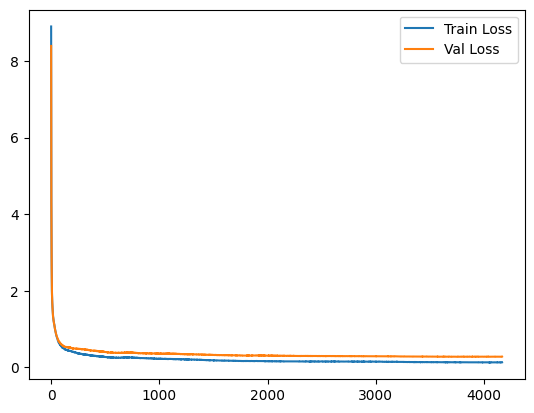

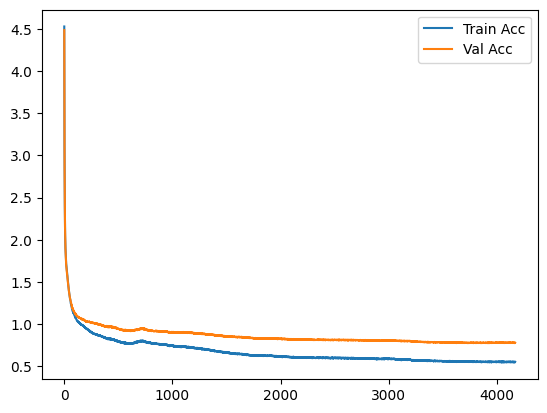

Fold 4 of 6 completed
Train Loss: 0.13141852800333795
Train Acc: 0.5545338274353587
Val Loss: 0.2788101176135583
Val Acc: 0.7803631347594635


Epochs:  35%|███▍      | 3468/10000 [03:47<07:08, 15.23it/s]


MSE [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-08 ('Nesterov', 0.0001) 0.0001


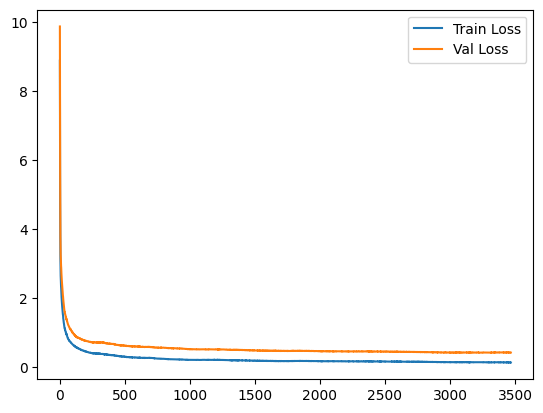

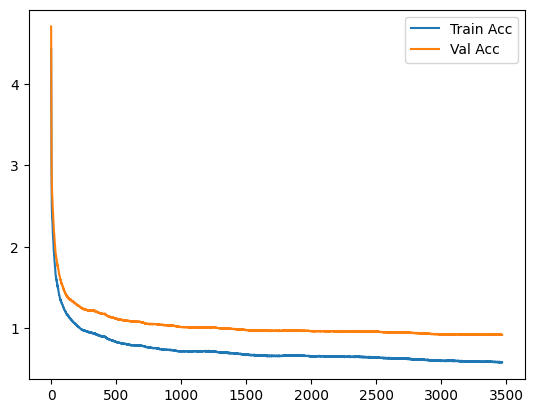

Fold 5 of 6 completed
Train Loss: 0.1435958399893954
Train Acc: 0.5806444146302814
Val Loss: 0.4312914889027655
Val Acc: 0.9187980414128444


Epochs:  30%|██▉       | 2973/10000 [03:15<07:42, 15.21it/s]


MSE [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-08 ('Nesterov', 0.0001) 0.0001


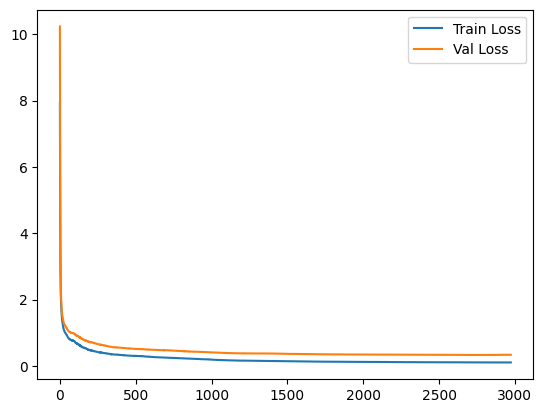

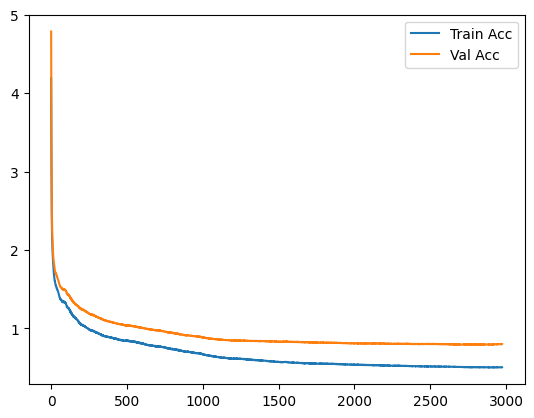

Fold 6 of 6 completed
Train Loss: 0.10733490087971412
Train Acc: 0.5033608734807627
Val Loss: 0.33856994362649234
Val Acc: 0.7996951562812838
{'tr_loss': 0.14731873642397889, 'tr_metric': 0.589763107154594, 'val_loss': 0.3470930865641649, 'val_metric': 0.8392014650191358}






Epochs:  19%|█▉        | 1932/10000 [01:56<08:05, 16.63it/s]


MSE [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-08 ('Standard', 0.0001) 0.0001


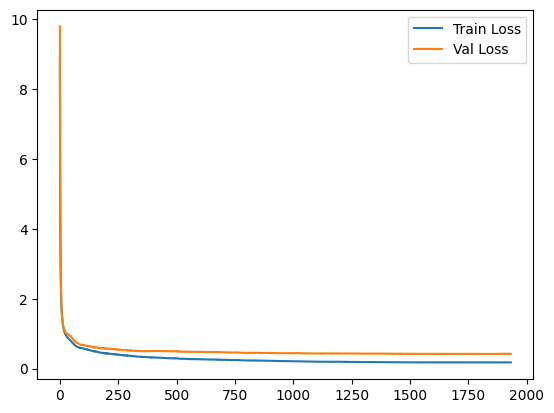

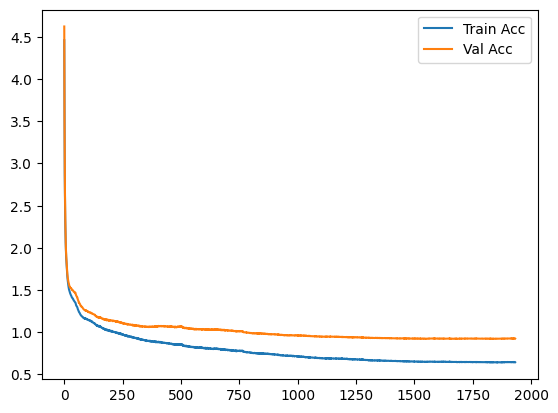

Fold 1 of 6 completed
Train Loss: 0.179668083192633
Train Acc: 0.6455743953431172
Val Loss: 0.42546306925156663
Val Acc: 0.925667752780934


Epochs:   7%|▋         | 665/10000 [00:40<09:23, 16.55it/s]


MSE [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-08 ('Standard', 0.0001) 0.0001


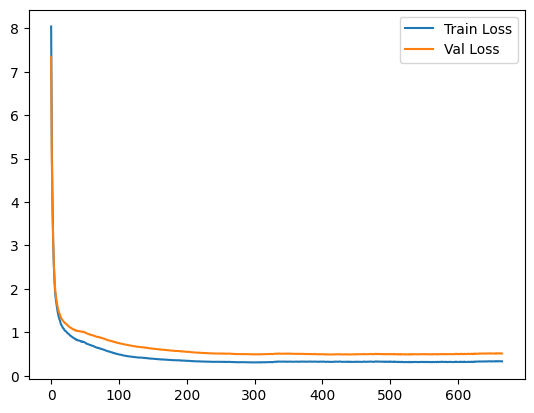

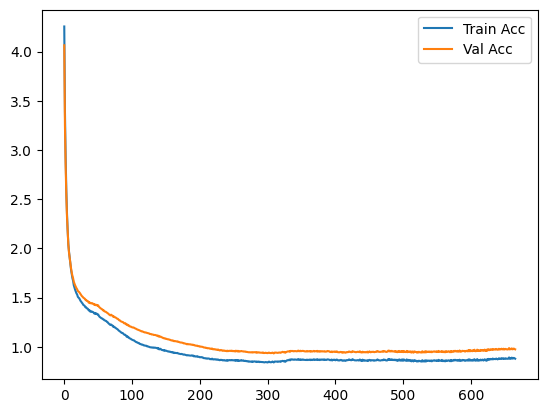

Fold 2 of 6 completed
Train Loss: 0.3319047443213457
Train Acc: 0.8777407685165083
Val Loss: 0.5123346693577171
Val Acc: 0.9728816190438335


Epochs:  22%|██▏       | 2244/10000 [02:15<07:46, 16.61it/s]


MSE [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-08 ('Standard', 0.0001) 0.0001


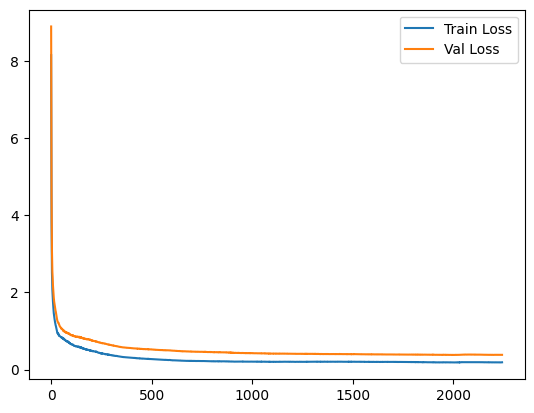

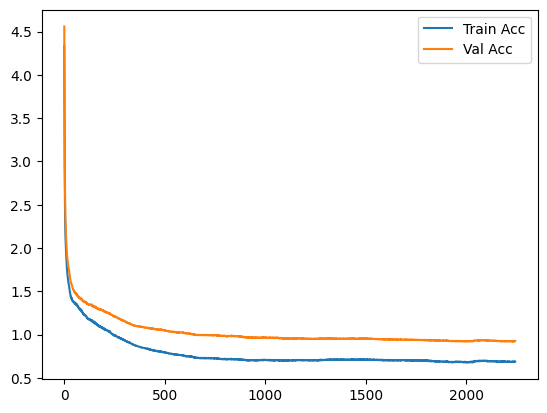

Fold 3 of 6 completed
Train Loss: 0.18852698964537132
Train Acc: 0.6875739267416724
Val Loss: 0.3821332600460491
Val Acc: 0.9233811970194835


Epochs:  35%|███▍      | 3476/10000 [03:28<06:31, 16.65it/s]


MSE [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-08 ('Standard', 0.0001) 0.0001


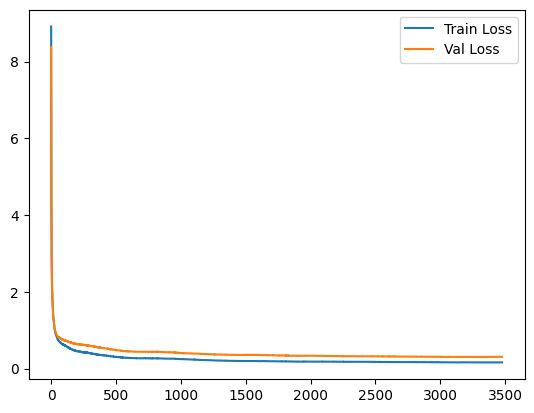

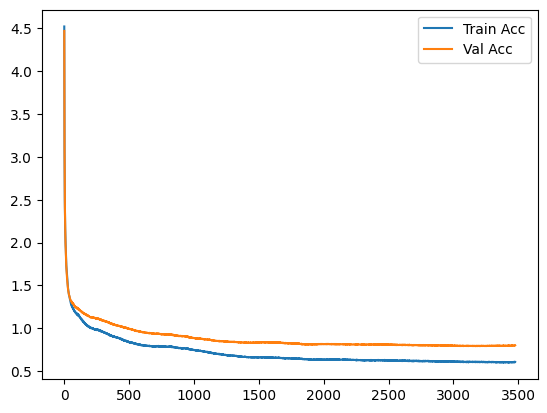

Fold 4 of 6 completed
Train Loss: 0.16003422733853226
Train Acc: 0.6066060387415728
Val Loss: 0.30556514142365876
Val Acc: 0.7999785820317432


Epochs:  20%|██        | 2034/10000 [02:02<08:00, 16.56it/s]


MSE [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-08 ('Standard', 0.0001) 0.0001


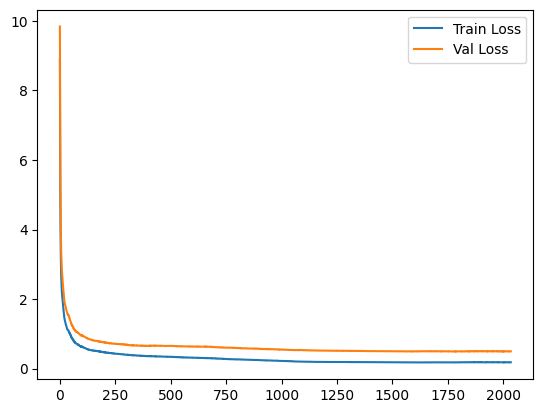

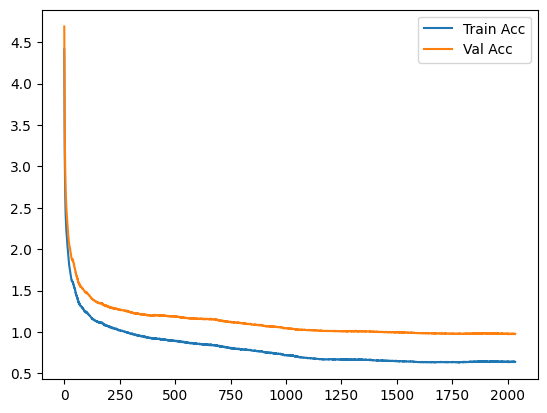

Fold 5 of 6 completed
Train Loss: 0.1836304395472544
Train Acc: 0.6412019563000765
Val Loss: 0.49828739208819667
Val Acc: 0.9784155600708209


Epochs:  69%|██████▉   | 6889/10000 [06:54<03:06, 16.64it/s]


MSE [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-08 ('Standard', 0.0001) 0.0001


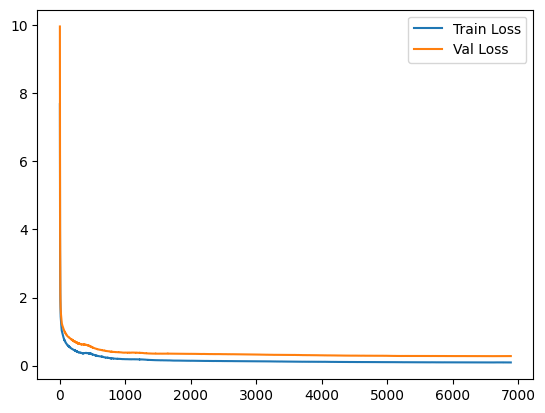

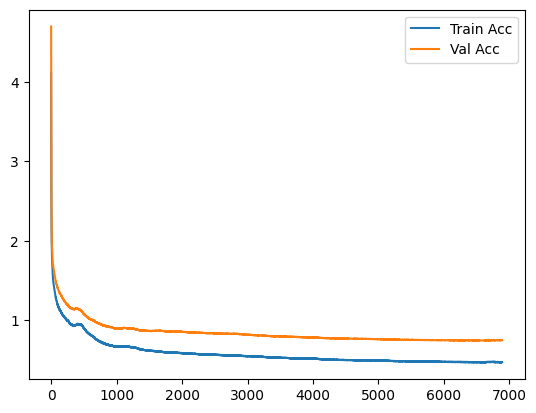

Fold 6 of 6 completed
Train Loss: 0.09232104226412764
Train Acc: 0.4716184185164945
Val Loss: 0.2794276660744204
Val Acc: 0.7496477461018651
{'tr_loss': 0.18569386618829917, 'tr_metric': 0.6484878707908773, 'val_loss': 0.39277735345149395, 'val_metric': 0.8822804456843958}






Epochs:   4%|▍         | 394/10000 [00:31<12:58, 12.34it/s]

MSE [16, 16, 16, 3] ReLU Range_random (-0.5, 0.5) L2 1e-06 ('Nesterov', 0.0001) 0.0001


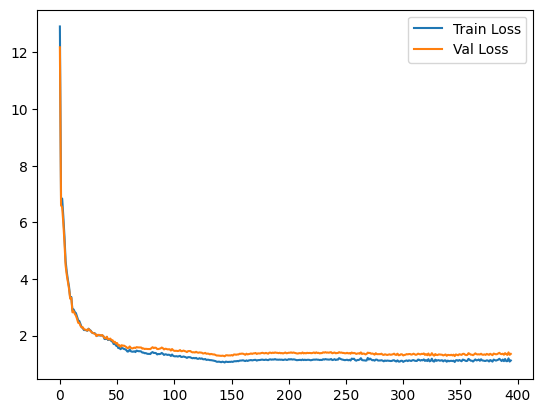

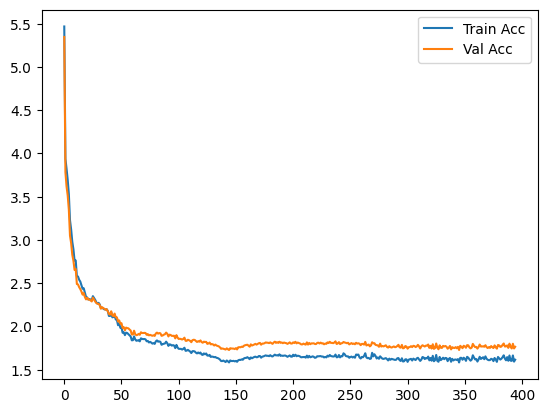

Fold 1 of 6 completed
Train Loss: 1.120840123557024
Train Acc: 1.6153680809756834
Val Loss: 1.3543589255552702
Val Acc: 1.7648601109079751


Epochs:   8%|▊         | 790/10000 [01:03<12:17, 12.48it/s]

MSE [16, 16, 16, 3] ReLU Range_random (-0.5, 0.5) L2 1e-06 ('Nesterov', 0.0001) 0.0001


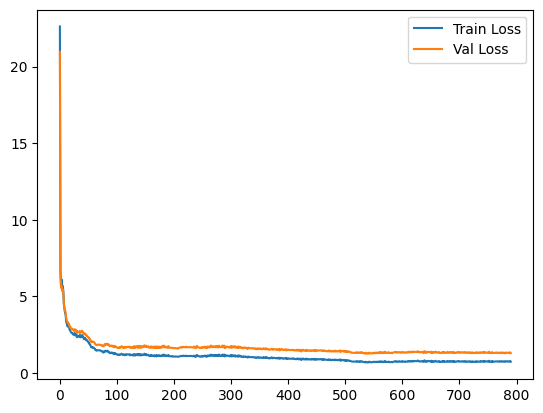

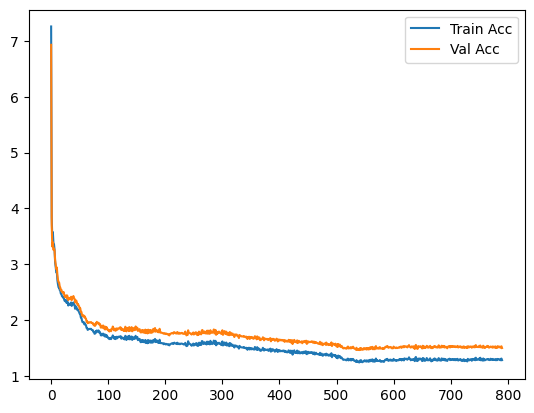

Fold 2 of 6 completed
Train Loss: 0.7258884761021505
Train Acc: 1.2833541977752225
Val Loss: 1.2848258139141489
Val Acc: 1.5004304628275305


Epochs:  17%|█▋        | 1742/10000 [02:20<11:04, 12.43it/s]

MSE [16, 16, 16, 3] ReLU Range_random (-0.5, 0.5) L2 1e-06 ('Nesterov', 0.0001) 0.0001


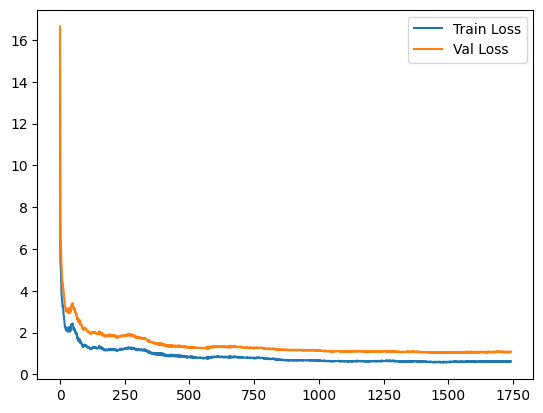

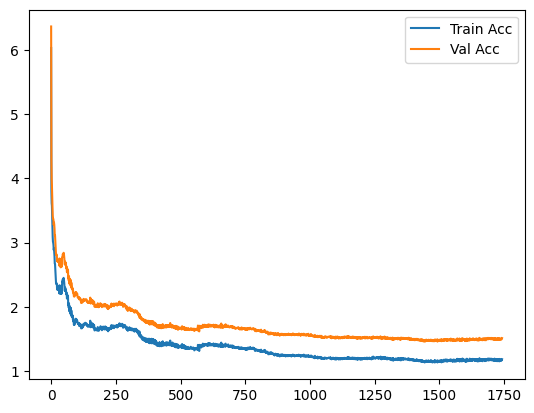

Fold 3 of 6 completed
Train Loss: 0.6287197080263864
Train Acc: 1.1831876326071442
Val Loss: 1.0933070285229318
Val Acc: 1.5116303327580534


Epochs:   6%|▌         | 569/10000 [00:45<12:41, 12.38it/s]


MSE [16, 16, 16, 3] ReLU Range_random (-0.5, 0.5) L2 1e-06 ('Nesterov', 0.0001) 0.0001


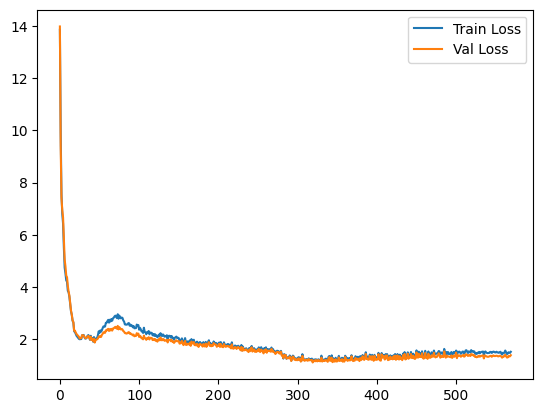

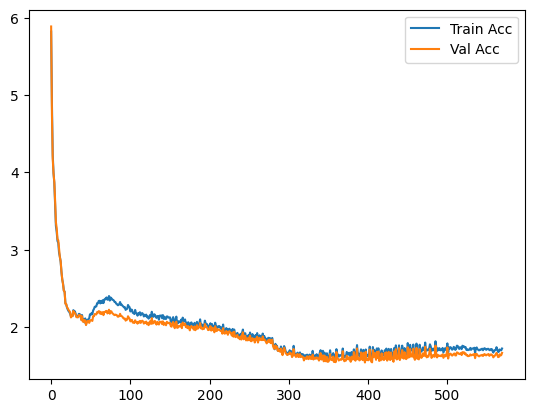

Fold 4 of 6 completed
Train Loss: 1.5113980949982728
Train Acc: 1.7222992281765637
Val Loss: 1.38055612128897
Val Acc: 1.6659576760144457


Epochs:  12%|█▏        | 1157/10000 [01:33<11:54, 12.38it/s]


MSE [16, 16, 16, 3] ReLU Range_random (-0.5, 0.5) L2 1e-06 ('Nesterov', 0.0001) 0.0001


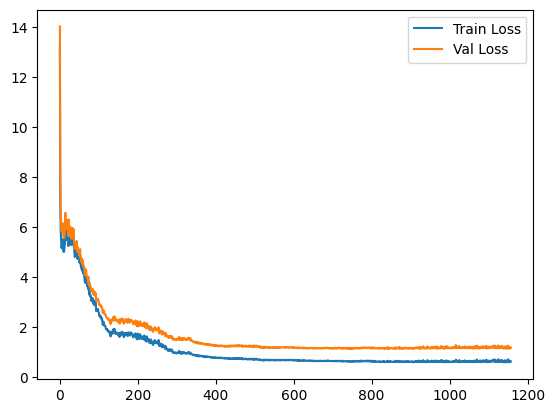

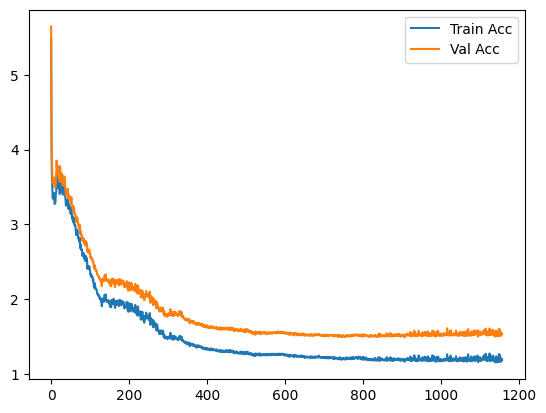

Fold 5 of 6 completed
Train Loss: 0.6061591440737347
Train Acc: 1.1874226691486776
Val Loss: 1.148871119487993
Val Acc: 1.5292952384131682


Epochs:  14%|█▎        | 1361/10000 [01:49<11:37, 12.38it/s]


MSE [16, 16, 16, 3] ReLU Range_random (-0.5, 0.5) L2 1e-06 ('Nesterov', 0.0001) 0.0001


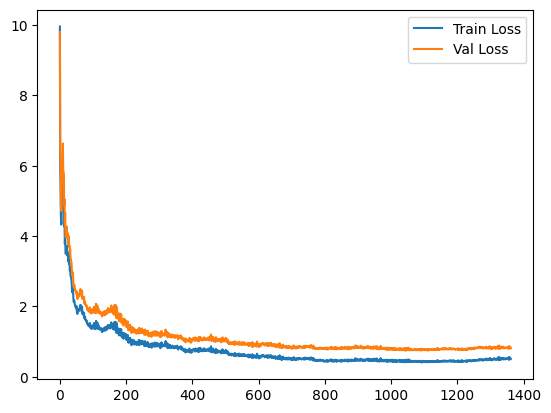

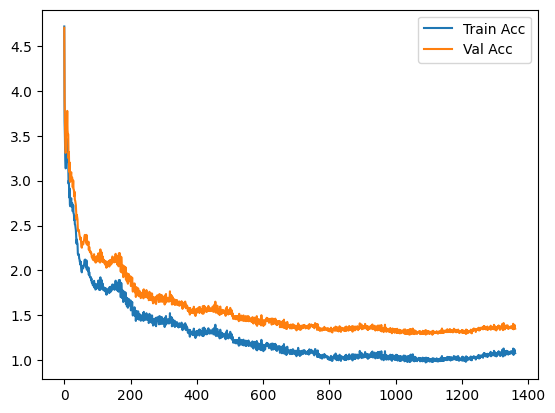

Fold 6 of 6 completed
Train Loss: 0.5058040903264156
Train Acc: 1.0767605161479314
Val Loss: 0.8104686868790331
Val Acc: 1.350266493138642
{'tr_loss': 0.7360218888192073, 'tr_metric': 1.2820515440849254, 'val_loss': 1.0832578323345832, 'val_metric': 1.498045396621005}






Epochs:  26%|██▌       | 2600/10000 [03:13<09:11, 13.41it/s]

MSE [16, 16, 16, 3] ReLU Range_random (-0.5, 0.5) L2 1e-06 ('Standard', 0.0001) 0.0001


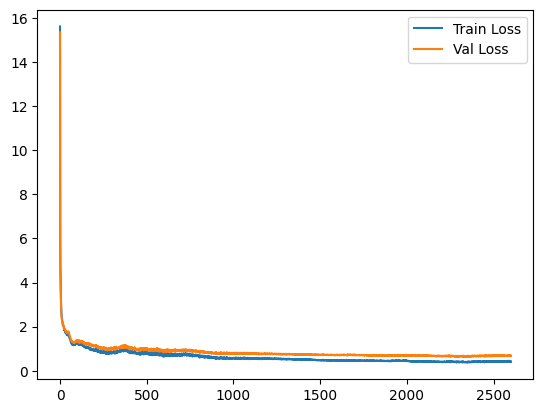

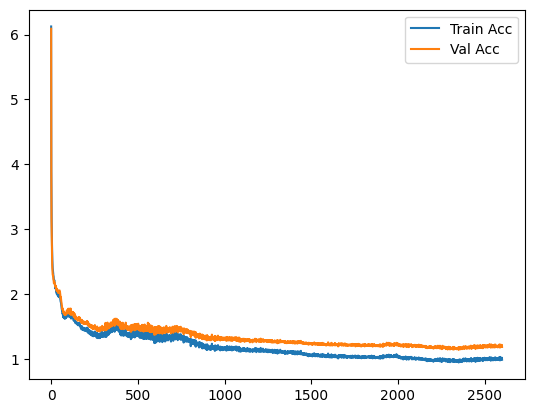

Fold 1 of 6 completed
Train Loss: 0.40784635907675065
Train Acc: 0.9910634868102534
Val Loss: 0.6676906516548027
Val Acc: 1.1875818270547205


Epochs:   5%|▍         | 460/10000 [00:34<11:50, 13.43it/s]

MSE [16, 16, 16, 3] ReLU Range_random (-0.5, 0.5) L2 1e-06 ('Standard', 0.0001) 0.0001


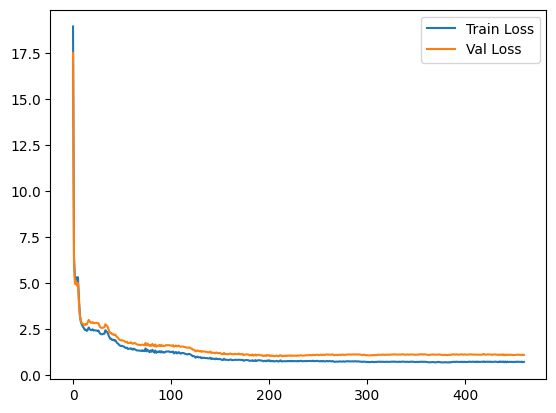

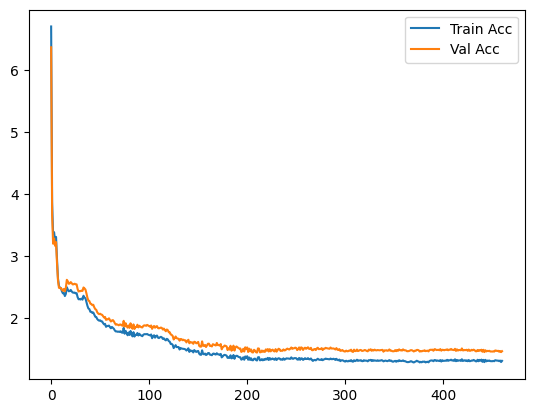

Fold 2 of 6 completed
Train Loss: 0.7116002074057359
Train Acc: 1.3072794462403472
Val Loss: 1.0974719652835483
Val Acc: 1.4634103999432815


Epochs:   3%|▎         | 331/10000 [00:24<12:06, 13.31it/s]


MSE [16, 16, 16, 3] ReLU Range_random (-0.5, 0.5) L2 1e-06 ('Standard', 0.0001) 0.0001


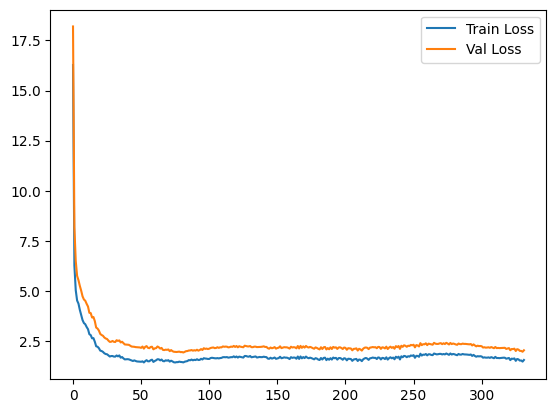

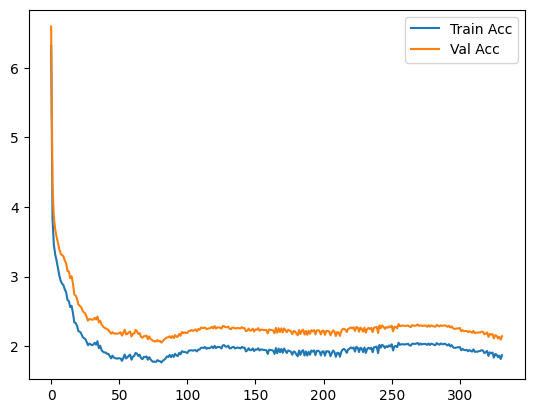

Fold 3 of 6 completed
Train Loss: 1.5625856362217039
Train Acc: 1.8700190611964524
Val Loss: 2.0462835983542527
Val Acc: 2.1418608768910885


Epochs:  12%|█▏        | 1246/10000 [01:33<10:53, 13.39it/s]


MSE [16, 16, 16, 3] ReLU Range_random (-0.5, 0.5) L2 1e-06 ('Standard', 0.0001) 0.0001


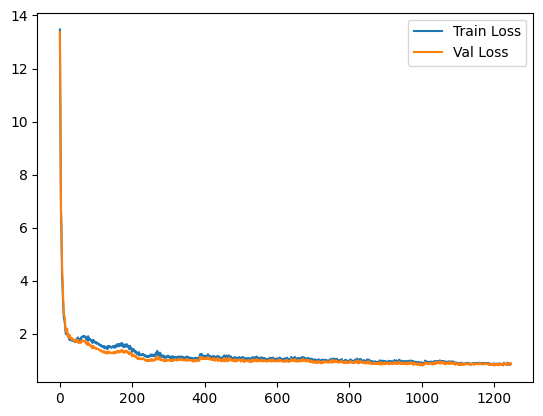

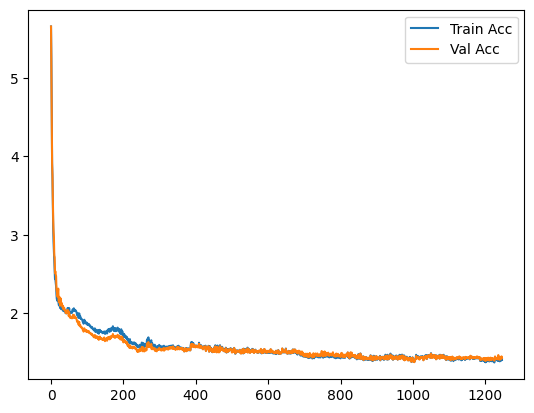

Fold 4 of 6 completed
Train Loss: 0.8545519069955967
Train Acc: 1.408360439032406
Val Loss: 0.8651752773954506
Val Acc: 1.4324306521892023


Epochs:  12%|█▏        | 1225/10000 [01:31<10:58, 13.33it/s]


MSE [16, 16, 16, 3] ReLU Range_random (-0.5, 0.5) L2 1e-06 ('Standard', 0.0001) 0.0001


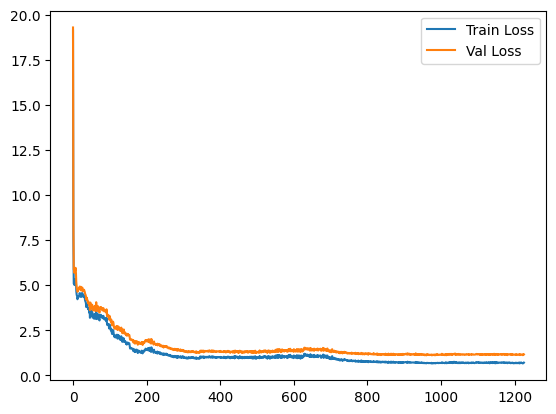

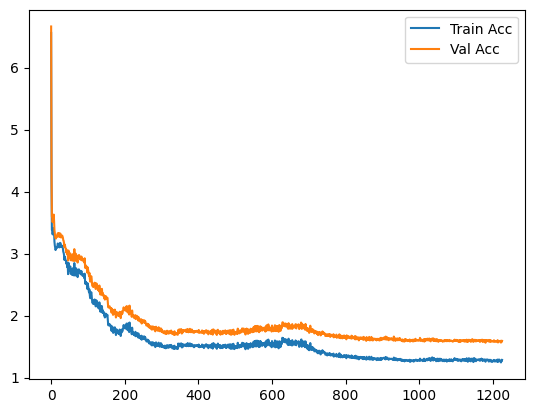

Fold 5 of 6 completed
Train Loss: 0.7080193863373428
Train Acc: 1.2847158399392953
Val Loss: 1.162705591950263
Val Acc: 1.5918546886645233


Epochs:   8%|▊         | 783/10000 [00:58<11:27, 13.41it/s]


MSE [16, 16, 16, 3] ReLU Range_random (-0.5, 0.5) L2 1e-06 ('Standard', 0.0001) 0.0001


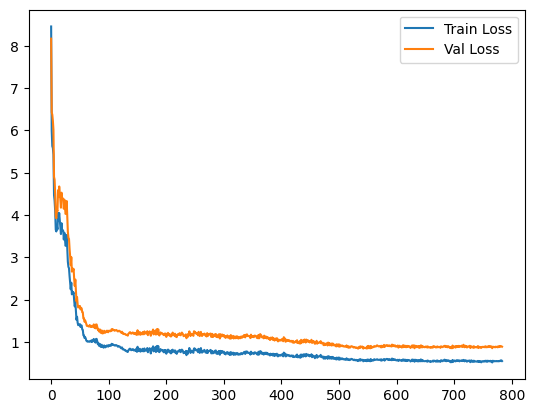

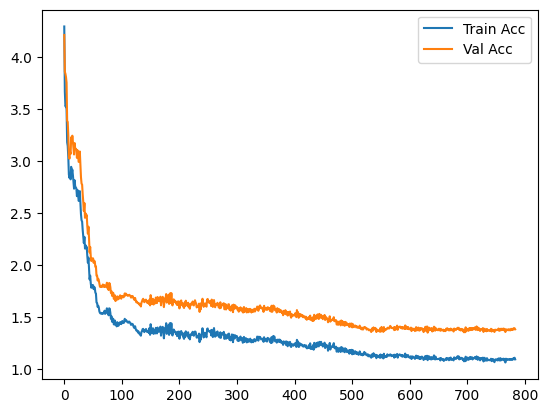

Fold 6 of 6 completed
Train Loss: 0.5542768998412553
Train Acc: 1.0943047118997307
Val Loss: 0.8931601432595193
Val Acc: 1.3833756066741285
{'tr_loss': 0.7676084459058891, 'tr_metric': 1.2941896086382456, 'val_loss': 1.0595352086538583, 'val_metric': 1.4918748985681631}






Epochs:   8%|▊         | 798/10000 [01:04<12:22, 12.40it/s]

MSE [16, 16, 16, 3] ReLU Range_random (-0.5, 0.5) L2 1e-08 ('Nesterov', 0.0001) 0.0001


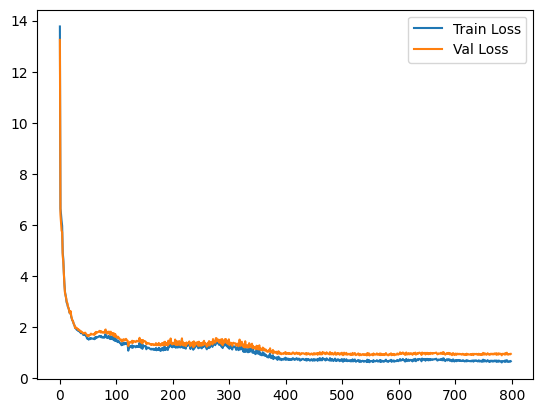

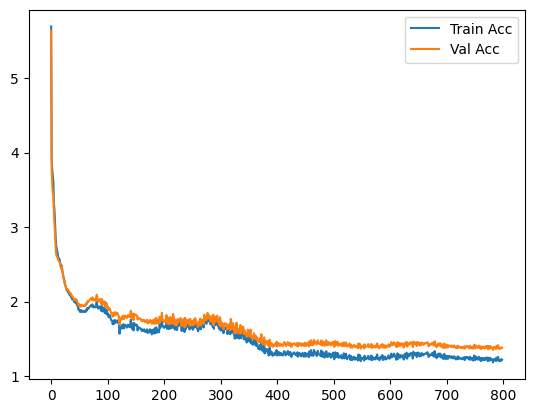

Fold 1 of 6 completed
Train Loss: 0.6520390898989892
Train Acc: 1.2211928021333647
Val Loss: 0.9409847177633273
Val Acc: 1.3793763400853039


Epochs:  16%|█▋        | 1646/10000 [02:12<11:11, 12.44it/s]

MSE [16, 16, 16, 3] ReLU Range_random (-0.5, 0.5) L2 1e-08 ('Nesterov', 0.0001) 0.0001


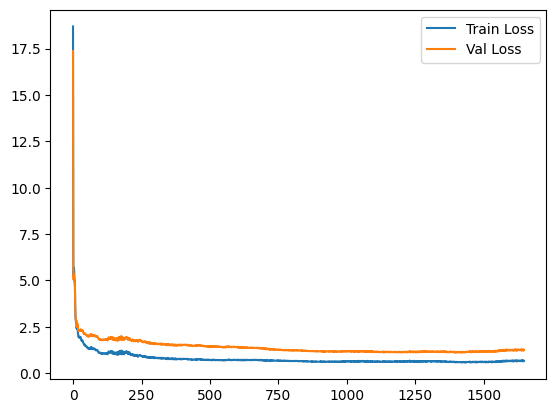

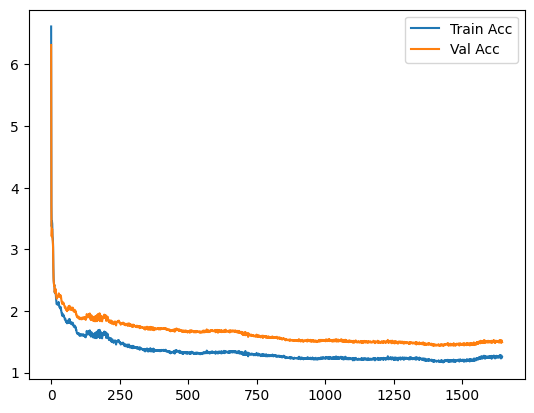

Fold 2 of 6 completed
Train Loss: 0.6609886837228939
Train Acc: 1.252142870849197
Val Loss: 1.2467841577733154
Val Acc: 1.4937002573761313


Epochs:   6%|▋         | 645/10000 [00:52<12:37, 12.35it/s]

MSE [16, 16, 16, 3] ReLU Range_random (-0.5, 0.5) L2 1e-08 ('Nesterov', 0.0001) 0.0001


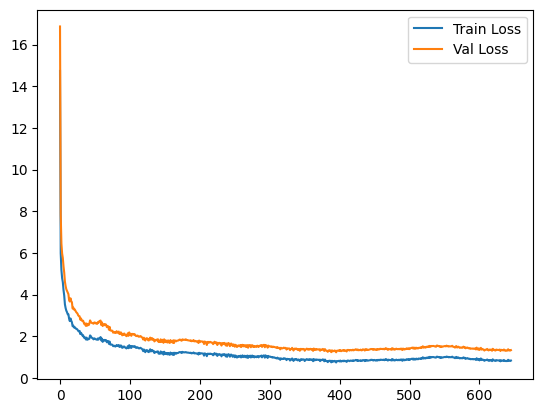

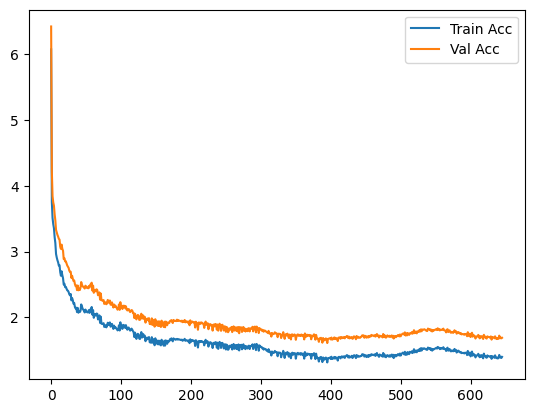

Fold 3 of 6 completed
Train Loss: 0.8372174406570847
Train Acc: 1.401839850735589
Val Loss: 1.3372355374479061
Val Acc: 1.6913058970077992


Epochs:   9%|▉         | 940/10000 [01:15<12:10, 12.40it/s]

MSE [16, 16, 16, 3] ReLU Range_random (-0.5, 0.5) L2 1e-08 ('Nesterov', 0.0001) 0.0001


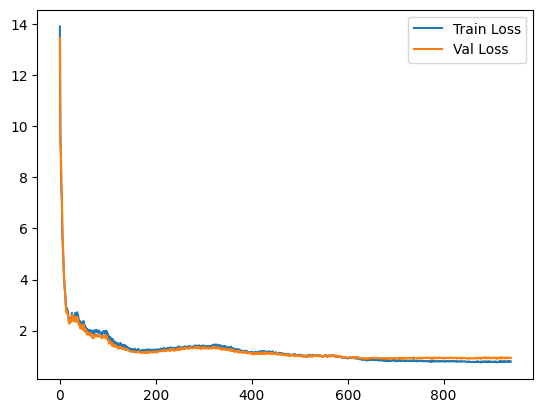

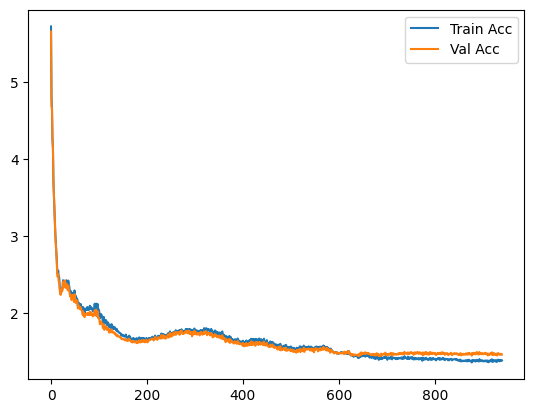

Fold 4 of 6 completed
Train Loss: 0.7887598016852687
Train Acc: 1.384382920501978
Val Loss: 0.9231096737272402
Val Acc: 1.4610090758898842


Epochs:   6%|▌         | 605/10000 [00:48<12:38, 12.39it/s]


MSE [16, 16, 16, 3] ReLU Range_random (-0.5, 0.5) L2 1e-08 ('Nesterov', 0.0001) 0.0001


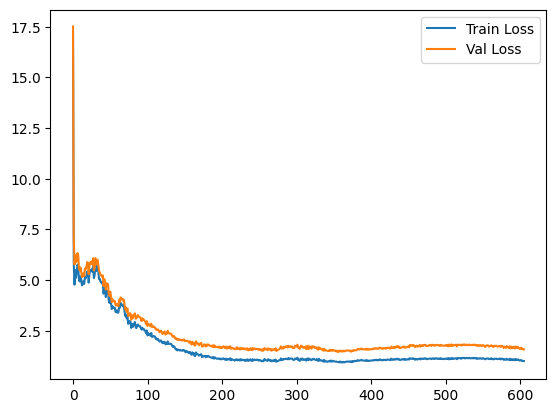

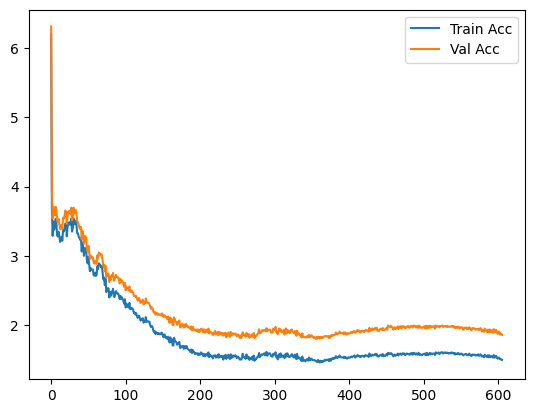

Fold 5 of 6 completed
Train Loss: 1.010981061908062
Train Acc: 1.5007416092564987
Val Loss: 1.5859862601518793
Val Acc: 1.8624828659882433


Epochs:   5%|▌         | 521/10000 [00:42<12:50, 12.30it/s]


MSE [16, 16, 16, 3] ReLU Range_random (-0.5, 0.5) L2 1e-08 ('Nesterov', 0.0001) 0.0001


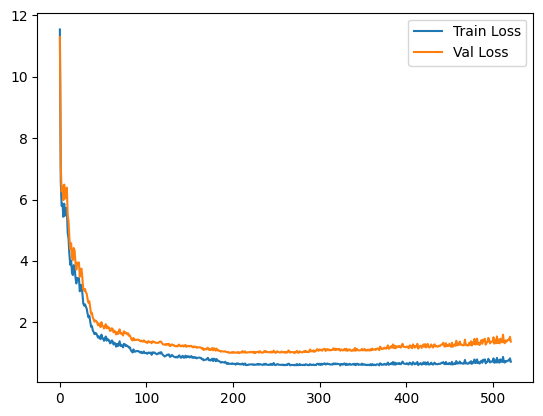

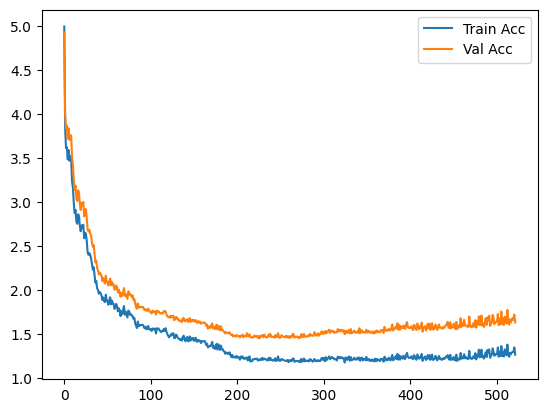

Fold 6 of 6 completed
Train Loss: 0.7108659768779857
Train Acc: 1.2674060109334742
Val Loss: 1.3666572646276494
Val Acc: 1.6346606202657836
{'tr_loss': 0.7178702924191773, 'tr_metric': 1.2940454676382431, 'val_loss': 1.094683177878574, 'val_metric': 1.5197138472053986}






Epochs:   6%|▌         | 571/10000 [00:42<11:44, 13.38it/s]


MSE [16, 16, 16, 3] ReLU Range_random (-0.5, 0.5) L2 1e-08 ('Standard', 0.0001) 0.0001


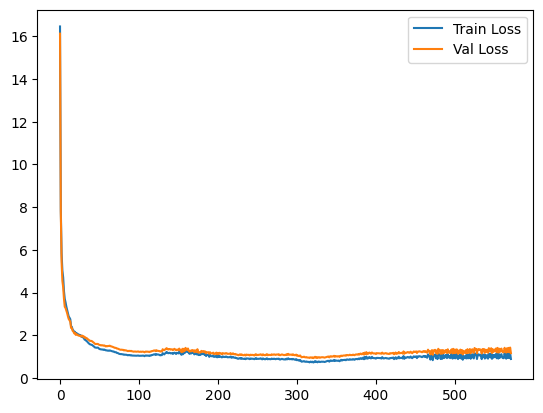

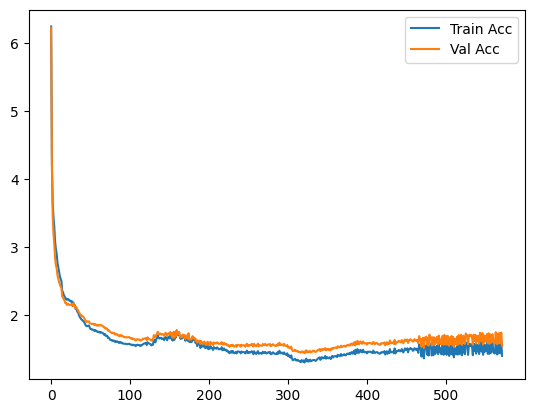

Fold 1 of 6 completed
Train Loss: 0.8850738757260707
Train Acc: 1.3945040205141779
Val Loss: 1.1607167880215805
Val Acc: 1.544586166591174


Epochs:   8%|▊         | 830/10000 [01:01<11:22, 13.44it/s]

MSE [16, 16, 16, 3] ReLU Range_random (-0.5, 0.5) L2 1e-08 ('Standard', 0.0001) 0.0001


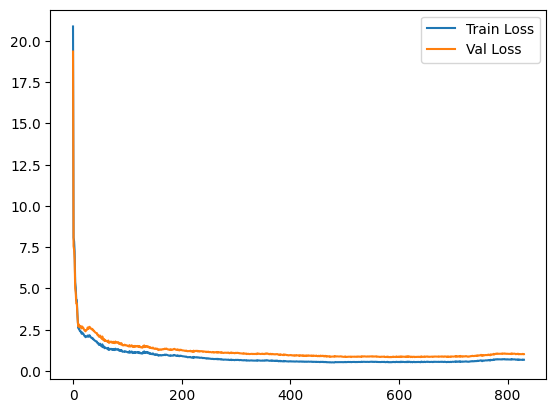

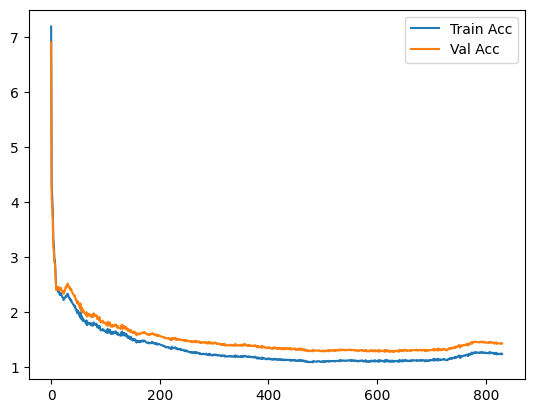

Fold 2 of 6 completed
Train Loss: 0.6793012258279537
Train Acc: 1.233913813092556
Val Loss: 1.0182039931195774
Val Acc: 1.4249044360837921


Epochs:   6%|▋         | 641/10000 [00:47<11:38, 13.40it/s]


MSE [16, 16, 16, 3] ReLU Range_random (-0.5, 0.5) L2 1e-08 ('Standard', 0.0001) 0.0001


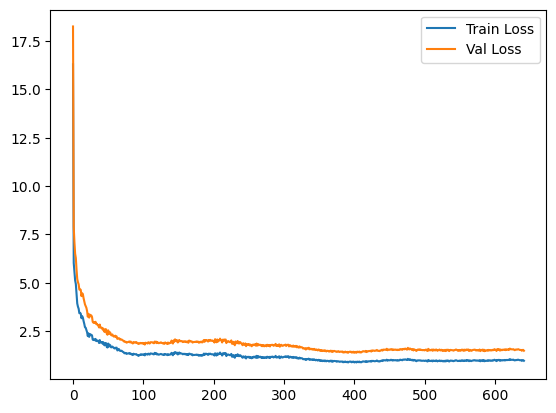

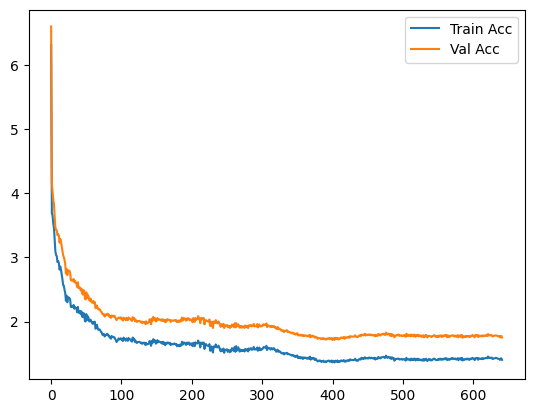

Fold 3 of 6 completed
Train Loss: 0.9696421882281898
Train Acc: 1.4016349506563865
Val Loss: 1.4886461850910764
Val Acc: 1.7494066570979454


Epochs:  12%|█▏        | 1186/10000 [01:28<10:57, 13.40it/s]

MSE [16, 16, 16, 3] ReLU Range_random (-0.5, 0.5) L2 1e-08 ('Standard', 0.0001) 0.0001


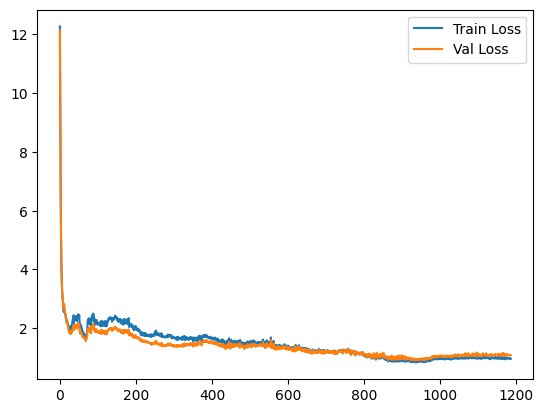

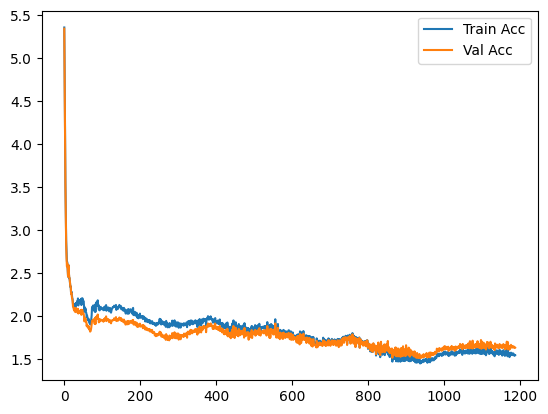

Fold 4 of 6 completed
Train Loss: 0.962967594874051
Train Acc: 1.548309748584182
Val Loss: 1.0764202648448429
Val Acc: 1.6348645935971806


Epochs:  18%|█▊        | 1780/10000 [02:12<10:12, 13.41it/s]

MSE [16, 16, 16, 3] ReLU Range_random (-0.5, 0.5) L2 1e-08 ('Standard', 0.0001) 0.0001


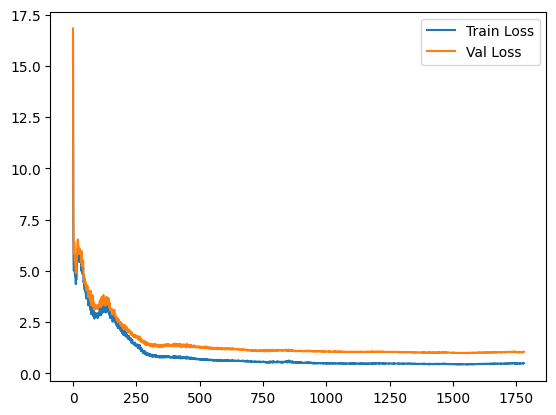

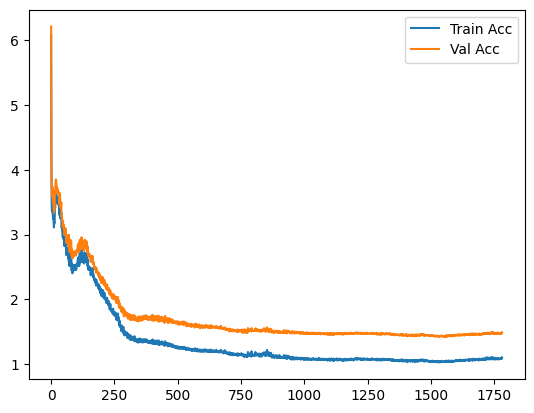

Fold 5 of 6 completed
Train Loss: 0.498811693294011
Train Acc: 1.1003515893702056
Val Loss: 1.050787762397351
Val Acc: 1.4880190768492805


Epochs:  18%|█▊        | 1756/10000 [02:10<10:13, 13.45it/s]


MSE [16, 16, 16, 3] ReLU Range_random (-0.5, 0.5) L2 1e-08 ('Standard', 0.0001) 0.0001


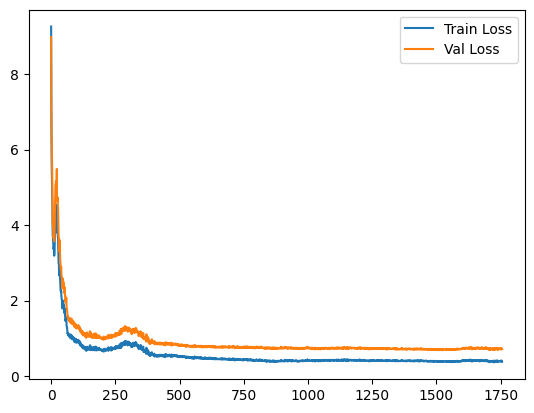

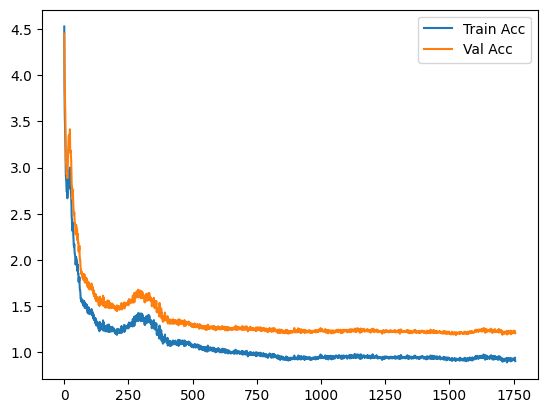

Fold 6 of 6 completed
Train Loss: 0.3795634478144438
Train Acc: 0.904062863667653
Val Loss: 0.7100568628064924
Val Acc: 1.2054493358533833
{'tr_loss': 0.6303718196292721, 'tr_metric': 1.1912600533850048, 'val_loss': 0.9530990981106225, 'val_metric': 1.4266456167855732}






In [5]:
seed = 3
data_to_csv = [[]]
losses_ = "MSE"

for combination in all_dics:
    layers_sizes_ = combination['layers_sizes']
    activations_ = []
    startings_ = []
    startings_range_ = []
    regularizers_ = []
    regularizers_lambda_ = []
    momentums_ = []
    etas_ = combination['etas']
    for i in range(len(combination['layers_sizes'])):
        activations_.append(combination['activations'] if i != len(layers_sizes_)-1 else "Identity")
        startings_.append(combination['startings'])
        startings_range_.append(combination['startings_range'])
        regularizers_.append(combination['regularizers'])
        regularizers_lambda_.append(combination['regularizers_lambda'])
        momentums_.append(combination['momentums'])
    net = create_all_net(
        seed=seed,
        loss="MSE",
        batch_size=1,
        input_size=len(X_train[0]),
        num_layer=len(layers_sizes_),
        layers_size=layers_sizes_,
        activations=activations_,
        starting=startings_,
        starting_range=startings_range_,
        regularizers=regularizers_,
        regularizers_lambda=regularizers_lambda_,
        momentums=momentums_,
        eta=etas_
        )
    statistics = kfold_crossval(
        X=X_train,
        y=y_train,
        k=6,
        net=net,
        epochs=10000,
        patience=250,
        seed=seed,
        metric=MEE(),
        comb=combination
        )
    print(statistics)
    print("\n\n\n")
    data_to_csv.append(list(combination.values()) + list(statistics.values()))


In [6]:
import csv

csv_file_path = '../statistics/test.csv'
with open(csv_file_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    # Write the data to the CSV file
    for row in data_to_csv:
        writer.writerow(row)    